In [128]:
import os
import librosa
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import noisereduce as nr
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Reshape, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ReduceLROnPlateau, History

In [165]:
def parse_filename(filename):
    parts = filename.split('-')
    modality, vocal_channel, emotion, intensity, statement, repetition, actor = parts
    return {
        'modality': modality,
        'vocal_channel': vocal_channel,
        'emotion': emotion,
        'intensity': intensity,
        'statement': statement,
        'repetition': repetition,
        'actor': actor
    }


def get_emotion_from_filename(filename):
    # Emotion coding mapping for the first dataset
    emotion_mapping = {
        '01': 'neutral', '02': 'neutral', '03': 'happy',
        '04': 'sad', '05': 'angry', '06': 'fear',
        '07': 'disgust', '08': 'ps'
    }

    # Known emotions for the second dataset
    known_emotions_2nd_group = ['angry', 'disgust', 'fear', 'happy', 'ps', 'sad', 'neutral']

    # Check to see if the format of the first set of data
    if '-' in filename:
        parts = filename.split('-')
        emotion_code = parts[2]
        return emotion_mapping.get(emotion_code, None)

    # Check to see if the format of the second set of data
    for emotion in known_emotions_2nd_group:
        if emotion in filename:
            return emotion

    return None  # Returns None if there are no matching emotions


def list_audio_files_recursively(path):
    # Recursively list all files in a directory and its subdirectories
    audio_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                audio_files.append(os.path.join(root, file))
    return audio_files


def compute_stft_and_db(y, sr):
    # Calculate STFT
    stft = librosa.stft(y)
    # Calculate the magnitude of the STFT
    stft_magnitude = np.abs(stft)
    # Convert to decibels
    stft_db = librosa.amplitude_to_db(stft_magnitude)
    return stft_db


def compute_frame_energy_and_z_scores(stft_db):
    # Calculate the energy per frame
    frame_energies = np.sum(np.square(stft_db), axis=0)
    # 
    frame_energies_z_scores = zscore(frame_energies)
    return frame_energies_z_scores


def identify_anomalous_frames(frame_energies_z_scores, threshold=2.0):
    # Normalized to Z-score
    anomalous_frames = np.where(np.abs(frame_energies_z_scores) > threshold)[0]
    return anomalous_frames


def replace_anomalous_frames(y, anomalous_frames, sr):
    for frame_index in anomalous_frames:
        # Calculate the start and end position of the frame
        start = max(0, frame_index - 1)
        end = min(len(y), frame_index + 2)

        # Interpolation strategy: take the average of the front and back frames
        if start < len(y) and end < len(y):
            y[frame_index] = (y[start] + y[end]) / 2
    return y


def enhance_audio_features(file_path, prop_decrease=0.8, add_noise=False,freq_mask_smooth_hz=700,n_fft=2048, identify_anomalies=False):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Apply noise reduction
    reduced_noise_audio = nr.reduce_noise(y=y, sr=sr, freq_mask_smooth_hz=freq_mask_smooth_hz,n_fft=n_fft, prop_decrease=prop_decrease)

    # Data Augmentation
    if add_noise:
        # Adding random noise
        noise_amp = 0.003*np.random.uniform()*np.amax(y)
        y = y + noise_amp * np.random.normal(size=y.shape[0])

    # identify anomalous frames
    if identify_anomalies:
        stft_db = compute_stft_and_db(y, sr)
        frame_energies_z_scores = compute_frame_energy_and_z_scores(stft_db)
        anomalous_frames = identify_anomalous_frames(frame_energies_z_scores)
        return y, anomalous_frames

    return y, None

def organize_files_by_emotion(path):
    audio_files = list_audio_files_recursively(path)
    emotion_files = {}
    for file in audio_files:
        emotion = get_emotion_from_filename(os.path.basename(file))
        if emotion not in emotion_files:
            emotion_files[emotion] = []
        emotion_files[emotion].append(file)
    return emotion_files

In [166]:
def prepare_datasets(emotion_files, n_mfcc=15, audio_length=44100, test_size=0.3, val_size=0.5):
    """
    Prepare training set, validation set and test set.

    :param emotion_files: Dictionary of audio files categorized by emotion.
    :param n_mfcc: Number of MFCCs to compute.
    :param audio_length: Audio length normalization.
    :param test_size: Percentage of the test set.
    :param val_size: Proportion of validation set in the test set.
    :return: Split training set, validation set and test set.
    """
    features = []
    labels = []

    for emotion, files in emotion_files.items():
        for file in files:
            y, sr = librosa.load(file, sr=None)
            # Apply audio enhancement
            y, anomalous_frames = enhance_audio_features(file, add_noise=True, identify_anomalies=True)
            y = replace_anomalous_frames(y, anomalous_frames, sr)
            
            if len(y) > audio_length:
                y = y[:audio_length]
            else:
                y = np.pad(y, (0, max(0, audio_length - len(y))), "constant")

            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            
                                                           
            # Convert MFCC to a form suitable for CNN inputs
            mfcc = mfcc.T
            if mfcc.shape[0] < audio_length // 512:
                pad_width = audio_length // 512 - mfcc.shape[0]
                mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')

            features.append(mfcc[..., np.newaxis])  #Add a new dimension
            labels.append(emotion)

    # Convert to NumPy Array
    features = np.array(features)
    labels = np.array(labels)

    # Convert labels to numeric
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform(labels)

    # Convert numeric labels to one-hot encoding
    one_hot_labels = to_categorical(numeric_labels)

    # data segmentation
    x_train, x_test, t_train, t_test = train_test_split(features, one_hot_labels, test_size=test_size, random_state=42)
    x_val, x_test, t_val, t_test = train_test_split(x_test, t_test, test_size=val_size, random_state=42)

    return x_train, x_val, x_test, t_train, t_val, t_test

In [167]:
    # path to the file
    path_to_audio_files1 = "D:/BaiduNetdiskDownload/pythonProject/speech_actors_01-24"
    data1 = organize_files_by_emotion(path_to_audio_files1)
    path_to_audio_files2 = "D:/BaiduNetdiskDownload/pythonProject/TESS"
    data2 = organize_files_by_emotion(path_to_audio_files2)

    combined_dict = {}
    for key in set(data1.keys()).union(data2.keys()):
        combined_dict[key] = data1.get(key, []) + data2.get(key, [])

    print(combined_dict.keys())

dict_keys(['disgust', 'neutral', 'fear', 'sad', 'ps', 'angry', 'happy'])


In [168]:
    x_train, x_val, x_test, t_train, t_val, t_test = prepare_datasets(combined_dict)

    print("done")

done


In [169]:
  print(x_train[0])
  print(t_train[0])
  print(x_train.shape)
  print(t_train.shape)

  print(x_val.shape)
  print(t_val.shape)

  print(x_test.shape)
  print(t_test.shape)

[[[-436.85190958]
  [ -42.37877646]
  [  31.54640532]
  ...
  [   7.31348433]
  [   8.29214256]
  [   3.25881587]]

 [[-384.93547186]
  [ -60.15211926]
  [  45.66425231]
  ...
  [   5.78277454]
  [  11.71570642]
  [   1.63677928]]

 [[-378.00490271]
  [ -73.1776526 ]
  [  58.67531608]
  ...
  [   5.02015296]
  [   8.93890544]
  [   3.60604364]]

 ...

 [[-373.14868511]
  [ -51.55044071]
  [  37.07569778]
  ...
  [  12.6232552 ]
  [   1.92033397]
  [   0.69442855]]

 [[-379.74707687]
  [ -90.46522831]
  [  41.24326471]
  ...
  [  13.50699802]
  [   3.88550677]
  [   1.79230219]]

 [[-389.96451374]
  [ -89.85017521]
  [  33.42462941]
  ...
  [   9.59053201]
  [   6.12225039]
  [   3.07451212]]]
[0. 0. 0. 1. 0. 0. 0.]
(2968, 87, 15, 1)
(2968, 7)
(636, 87, 15, 1)
(636, 7)
(636, 87, 15, 1)
(636, 7)


In [184]:
def build_model(input_shape, num_classes):
    model = Sequential()

    # CNN layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Flatten the output of the CNN and pass it to the RNN
    model.add(Flatten())
    model.add(Reshape((-1, 128)))

    # RNN layer
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))

    # full connectivity layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [201]:
input_shape = (87, 15, 1)  # None means that the length of the time series is variable
num_classes = 7
model = build_model(input_shape, num_classes)


# Model overview
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 85, 13, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 42, 6, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 42, 6, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 40, 4, 64)         18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 20, 2, 64)         0         
 ng2D)                                                           
                                                     

In [202]:
def train_model(model, x_train, y_train, x_val, y_val, initial_lr=0.001, epochs=20, batch_size=32):
    """
    Trains the model and returns the history object.

    :param model: The neural network model to build.
    :param x_train: The training dataset.
    :param y_train: Training labels.
    :param x_val: Validation dataset.
    :param y_val: Validation labels.
    :param initial_lr: Initial learning rate.
    :param epochs: Training cycles.
    :param batch_size: Batch size.
    :return: Training history object.
    """
    # Setting up the optimizer
    optimizer = Adam(learning_rate=initial_lr)

    # Compilation model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Create callbacks for learning rate adjustments
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

    # Training models
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[reduce_lr])

    return history

def plot_training_history(history):
    """
    Plot training accuracy and loss curves.

    :param history: Training history object.
    """
    # Accuracy Curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/20
93/93 [==============================] - 4s 21ms/step - loss: 1.2651 - accuracy: 0.5091 - val_loss: 1.5693 - val_accuracy: 0.4104 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 1s 16ms/step - loss: 0.7407 - accuracy: 0.7214 - val_loss: 0.9832 - val_accuracy: 0.6336 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 2s 17ms/step - loss: 0.6670 - accuracy: 0.7463 - val_loss: 0.7725 - val_accuracy: 0.7091 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 2s 18ms/step - loss: 0.6147 - accuracy: 0.7675 - val_loss: 0.7001 - val_accuracy: 0.7421 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 2s 19ms/step - loss: 0.5942 - accuracy: 0.7665 - val_loss: 0.7021 - val_accuracy: 0.7327 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 2s 17ms/step - loss: 0.5882 - accuracy: 0.7726 - val_loss: 0.6520 - val_accuracy: 0.7594 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 2s 17ms/step - loss: 0.5

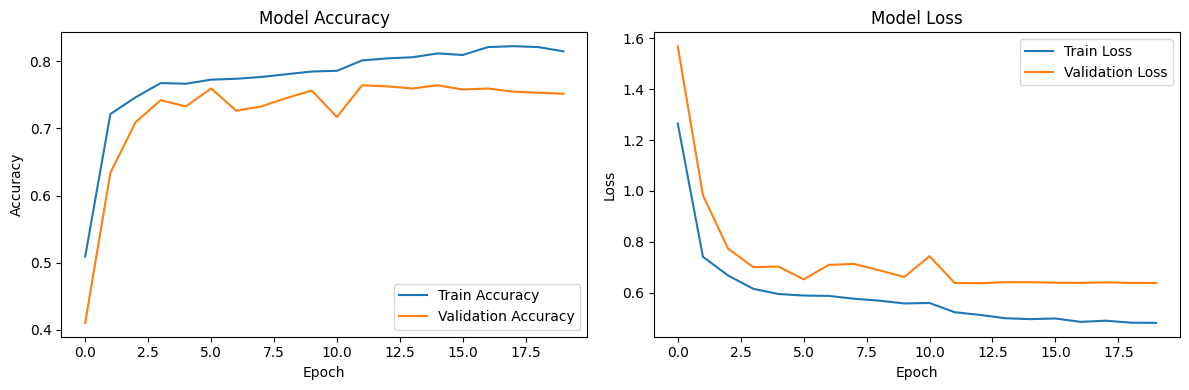

In [203]:
history = train_model(model, x_train, t_train, x_val, t_val, epochs=20, batch_size=32)
plot_training_history(history)

In [204]:
test_loss, test_accuracy = model.evaluate(x_test, t_test)

# Print test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 [==============================] - 0s 6ms/step - loss: 0.5645 - accuracy: 0.7893
Test Accuracy: 78.93%


In [220]:
def build_cnn_model(input_shape, num_classes):

    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(87, 15, 1)))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return cnn_model

In [221]:
cnn_model = build_cnn_model(input_shape, num_classes)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 85, 13, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 42, 6, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 42, 6, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 40, 4, 64)         18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 20, 2, 64)         0         
 ng2D)                                                           
                                                     

Epoch 1/20
93/93 [==============================] - 1s 10ms/step - loss: 14.0314 - accuracy: 0.2547 - val_loss: 1.7365 - val_accuracy: 0.3097 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 1s 8ms/step - loss: 1.6066 - accuracy: 0.3450 - val_loss: 1.5506 - val_accuracy: 0.3821 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 1s 8ms/step - loss: 1.3647 - accuracy: 0.4397 - val_loss: 1.3392 - val_accuracy: 0.4921 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 1s 8ms/step - loss: 1.1684 - accuracy: 0.5573 - val_loss: 1.1827 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 1s 8ms/step - loss: 1.0635 - accuracy: 0.6418 - val_loss: 1.0866 - val_accuracy: 0.6399 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 1s 8ms/step - loss: 0.9078 - accuracy: 0.6867 - val_loss: 0.9840 - val_accuracy: 0.6572 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 1s 8ms/step - loss: 0.8750 -

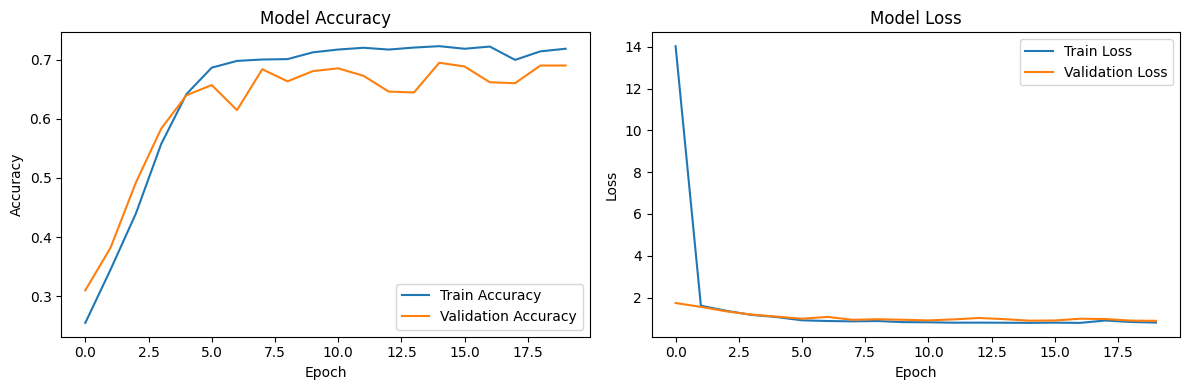

In [222]:
cnn_history = train_model(cnn_model, x_train, t_train, x_val, t_val, epochs=20, batch_size=32)
plot_training_history(cnn_history)

In [229]:
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(x_test, t_test)

# Print test accuracy
print(f"Test Accuracy: {cnn_test_accuracy * 100:.2f}%")

20/20 [==============================] - 0s 3ms/step - loss: 0.8248 - accuracy: 0.7170
Test Accuracy: 71.70%


In [225]:
def build_rnn_model(input_shape, num_classes):

    rnn_model = Sequential()
    rnn_model.add(LSTM(128, return_sequences=True, input_shape=(87, 15)))
    model.add(Dropout(0.2))
    rnn_model.add(LSTM(64))
    model.add(Dropout(0.2))
    rnn_model.add(Dense(64, activation='relu'))
    rnn_model.add(Dense(num_classes, activation='softmax'))

    rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return rnn_model

In [226]:
rnn_model = build_rnn_model(input_shape, num_classes)
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 85, 13, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 42, 6, 32)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 42, 6, 32)         128       
 tchNormalization)                                               
                                                                 
 conv2d_24 (Conv2D)          (None, 40, 4, 64)         18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 20, 2, 64)         0         
 ng2D)                                                           
                                                     

Epoch 1/20
93/93 [==============================] - 8s 57ms/step - loss: 1.4127 - accuracy: 0.4613 - val_loss: 1.0726 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 5s 53ms/step - loss: 0.8790 - accuracy: 0.6587 - val_loss: 0.8736 - val_accuracy: 0.6777 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 5s 52ms/step - loss: 0.7462 - accuracy: 0.7153 - val_loss: 0.8076 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 5s 53ms/step - loss: 0.7747 - accuracy: 0.7015 - val_loss: 0.8711 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 5s 50ms/step - loss: 0.7690 - accuracy: 0.7072 - val_loss: 0.8187 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 5s 52ms/step - loss: 0.6924 - accuracy: 0.7311 - val_loss: 0.8074 - val_accuracy: 0.6855 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 5s 53ms/step - loss: 0.6

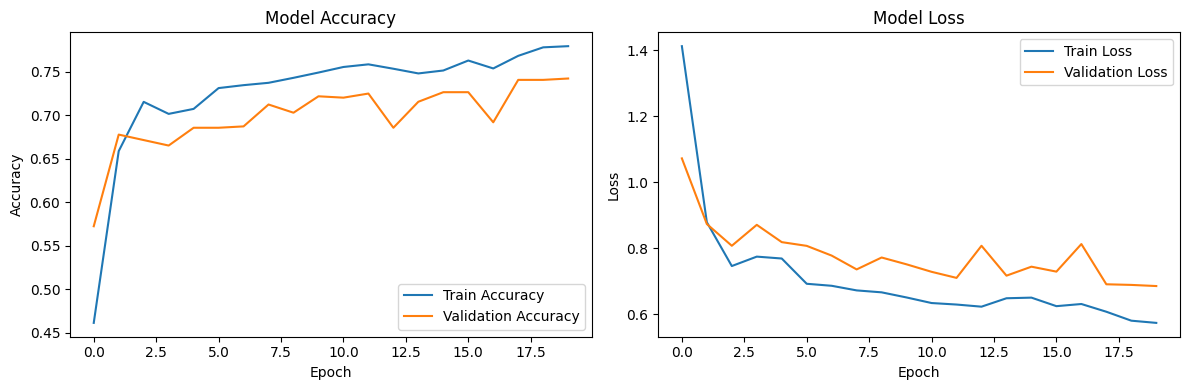

In [227]:
rnn_history = train_model(rnn_model, x_train, t_train, x_val, t_val, epochs=20, batch_size=32)
plot_training_history(rnn_history)

In [228]:
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(x_test, t_test)

# Print test accuracy
print(f"Test Accuracy: {rnn_test_accuracy * 100:.2f}%")

20/20 [==============================] - 0s 19ms/step - loss: 0.6069 - accuracy: 0.7579
Test Accuracy: 75.79%
